# Import Library

In [7]:
!pip install Levenshtein

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import pickle
from google.colab import files
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Concatenate, Attention, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from gensim.models import FastText
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from Levenshtein import distance as levenshtein_distance

In [9]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Understanding

In [10]:
'''
Get The Data - Jawa Language
'''

data = drive.CreateFile({'id':'1hNsvgOtWhEzVZ-6wd3clv-z7f4gthSBw'})
data.GetContentFile('Jawa.csv')

In [11]:
df = pd.read_csv('Jawa.csv')
df.head()

,pegon,latin
0,تاريخ,tariḵ
1,والى,wali
2,سڠا,sṅa
3,نࣤرَاڠَاكࣤنْ,něraṅakěn
4,بَبَادْاِيْفُونْ,babadipun


In [12]:
'''
Split Train and Testing Data
'''

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print("Shape of training set:", train_df.shape)
print("Shape of testing set:", test_df.shape)

Shape of training set: (2234, 2)
Shape of testing set: (249, 2)


# Data Preprocessing

In [13]:
def preprocess(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: '\t' + str(x).lower() + '\n')
    return df

In [14]:
'''
Convert to Lower Case and Add Start and End Token of the Latin Words
'''

train_df = preprocess(train_df, 'latin')
train_df.head()

,pegon,latin
1811,بَنْتُوَانَىْ,\tbantuane\n
1995,يَينْ,\tyen\n
1435,فَورْتࣤڮِيْس,\tfortěgis\n
1936,اِنْدُوْنِيْسِيَا,\tindunisia\n
1456,تِمْبُوْلَىْ,\ttimbule\n


In [15]:
def train_ft_model(sentences, window=5, vector_size=300, epochs=150, min_count=0, sg=1):
    model = FastText(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        epochs=epochs,
        min_count=min_count,
        sg=sg
    )
    return model

In [16]:
def create_tokenizer(column_data):
    # Create a tokenizer for character-level tokenization
    tokenizer = Tokenizer(char_level=True)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(column_data)

    return tokenizer

In [17]:
def create_input_sequences(column_data, tokenizer):
    # Get the size of the vocabulary (number of unique characters) plus one for padding
    char_size = len(tokenizer.word_index) + 1

    # Encode the text data into sequences of integers
    encoded = tokenizer.texts_to_sequences(column_data)

    # Find the maximum sequence length
    max_len = max(len(seq) for seq in encoded)

    # Pad the sequences to ensure uniform length
    padded = pad_sequences(encoded, maxlen=max_len, padding='post')

    return char_size, encoded, max_len, padded

In [18]:
# Create Pegon Character Tokenizer
pegon_tokenizer = create_tokenizer(train_df['pegon'])

# Create Latin Character Tokenizer
latin_tokenizer = create_tokenizer(train_df['latin'])

In [19]:
# Create Input Sequences of Pegon Words
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(train_df['pegon'], pegon_tokenizer)

# Create Input Sequences of Latin Words
latin_char_size, latin_encoded, latin_max_len, padded_latin = create_input_sequences(train_df['latin'], latin_tokenizer)

In [20]:
'''
Save Tokenizer
'''

filename = 'pegon_tokenizer_jawa.pkl'
pickle.dump(pegon_tokenizer, open(filename, 'wb'))
# files.download('pegon_tokenizer_jawa.pkl')

filename = 'latin_tokenizer_jawa.pkl'
pickle.dump(latin_tokenizer, open(filename, 'wb'))
# files.download('latin_tokenizer_jawa.pkl')

In [21]:
'''
Latin Token Index
'''

latin_index = latin_tokenizer.word_index
latin_df = pd.DataFrame(list(latin_index.items()), columns=['Char', 'Index'])
latin_df.set_index('Char', inplace=True)
latin_df

,Index
Char,
a,1
\t,2
\n,3
i,4
n,5
u,6
r,7
ě,8
m,9


In [22]:
'''
Pegon Token Index
'''

pegon_index = pegon_tokenizer.word_index
pegon_df = pd.DataFrame(list(pegon_index.items()), columns=['Char', 'Index'])
pegon_df.set_index('Char', inplace=True)
pegon_df

,Index
Char,
ْ,1
َ,2
ا,3
و,4
ِ,5
...,...
ظ,61
ٌ,62
ࢌ,63


In [23]:
'''
Check All of Variables
'''

print("Number of characters in Pegon:", pegon_char_size)
print("Number of characters in Latin:", latin_char_size)

print()

print("Example of Encoded Pegon:", pegon_encoded[0])
print("Example of Encoded Latin:", latin_encoded[0])

print()

print("Max Length of Encoded Pegon Sequences:", pegon_max_len)
print("Max Length of Encoded Latin Sequences", latin_max_len)


print()

print("Example of Encoded Pegon with Padding:", padded_pegon[0])
print("Example of Encoded Latin with Padding:", padded_latin[0])

Number of characters in Pegon: 66
Number of characters in Latin: 57

Example of Encoded Pegon: [19, 2, 6, 1, 17, 7, 4, 2, 3, 6, 2, 16, 1]
Example of Encoded Latin: [2, 16, 1, 5, 11, 6, 1, 5, 15, 3]

Max Length of Encoded Pegon Sequences: 21
Max Length of Encoded Latin Sequences 15

Example of Encoded Pegon with Padding: [19  2  6  1 17  7  4  2  3  6  2 16  1  0  0  0  0  0  0  0  0]
Example of Encoded Latin with Padding: [ 2 16  1  5 11  6  1  5 15  3  0  0  0  0  0]


In [24]:
'''
Train fastText model both Latin and Pegon
'''

vector_size = 300

pegon_vectorizer = train_ft_model(df['pegon'], vector_size)
latin_vectorizer = train_ft_model(df['latin'], vector_size)

In [25]:
'''
Save Vectorizer
'''

filename = 'pegon_vectorizer_jawa.pkl'
pickle.dump(pegon_vectorizer, open(filename, 'wb'))
# files.download('pegon_vectorizer_jawa.pkl')

filename = 'latin_vectorizer_jawa.pkl'
pickle.dump(latin_vectorizer, open(filename, 'wb'))
# files.download('latin_vectorizer_jawa.pkl')

In [26]:
def create_embedding_matrix(tokenizer, vectorizer):
    # Initialize embedding matrix
    char_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((char_size, vectorizer.vector_size))

    # Fill embedding matrix
    for char, i in tokenizer.word_index.items():
        embedding_vector = vectorizer.wv[char]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [27]:
'''
Create the Embedding Matrix for both Pegon and Latin
'''

pegon_emb_mat = create_embedding_matrix(pegon_tokenizer, pegon_vectorizer)
latin_emb_mat = create_embedding_matrix(latin_tokenizer, latin_vectorizer)


print("Example of Pegon Embedding Matrix:\n", pegon_emb_mat)
print("Example of Latin Embedding Matrix:\n", latin_emb_mat)

Example of Pegon Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00135567  0.0031567  -0.00880367 ... -0.03894535 -0.01420401
   0.01017934]
 [ 0.00057723  0.05378865 -0.05041439 ... -0.10619716 -0.01949255
   0.0323158 ]
 ...
 [-0.00342174 -0.0426546  -0.01649267 ... -0.02891473 -0.11099931
  -0.00026973]
 [ 0.0185961   0.09426353  0.03819515 ...  0.09626744 -0.07573246
   0.02726846]
 [ 0.01225275  0.08348254 -0.05756173 ...  0.05709974 -0.01037074
  -0.19860023]]
Example of Latin Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00314087  0.01831336  0.11232886 ... -0.03726033  0.04031879
  -0.00399561]
 [-0.00063902  0.00246553 -0.00065751 ...  0.00165612  0.0028372
  -0.00297938]
 ...
 [ 0.15363266  0.2859908   0.11258551 ... -0.01607183  0.16189834
   0.11128034]
 [ 0.03282899 -0.07373135  0.04835342 ...  0.06653356  0.03162335
  -0.03639007]
 [-0.0182506   0.07114165  0.16527936 ... -

In [28]:
'''
Split Train and Validation Data
'''

X_train, X_val, y_train, y_val = train_test_split(padded_pegon, padded_latin, test_size=1/9, random_state=42)

print("Shape of Pegon Train:", X_train.shape)
print("Shape of Latin Train:", y_train.shape)
print("Shape of Pegon Validation:", X_val.shape)
print("Shape of Latin Validation:", y_val.shape)

Shape of Pegon Train: (1985, 21)
Shape of Latin Train: (1985, 15)
Shape of Pegon Validation: (249, 21)
Shape of Latin Validation: (249, 15)


# Modelling

In [29]:
def compile_model(model):
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

In [30]:
def create_ft_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [31]:
def create_ft_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_outputs, forward_h, backward_h = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_outputs, _ = GRU(latent_dim*2, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [32]:
def create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [33]:
def create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, backward_h = encoder_gru(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [34]:
def train_model(model, X_train, X_val, y_train, y_val, epochs=100, batch_size=64, patience=10):
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]),
                        callbacks=[early_stopping])

    training_time_seconds = time.time() - start_time
    training_time_minutes = training_time_seconds / 60.0
    print(f"Training time: {training_time_minutes:.2f} minutes")

    return model, training_time_minutes, history

## Create Model

In [35]:
'''
Create bilstm_att Seq2Seq Model
'''

bilstm_att = create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bilstm_att.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 21, 512)              33792     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 21, 1024),           4198400   ['embedding[0][0]']           
 al)                          (None, 512),                                                    

In [36]:
'''
Create bigru_att Seq2Seq Model
'''

bigru_att = create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bigru_att.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 21, 512)              33792     ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  [(None, 21, 1024),           3151872   ['embedding_2[0][0]']         
 onal)                        (None, 512),                                                  

In [37]:
'''
Create ft_bilstm_att Seq2Seq Model
'''

ft_bilstm_att = create_ft_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
ft_bilstm_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 21, 300)              19800     ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_2 (Bidirecti  [(None, 21, 1024),           3330048   ['embedding_4[0][0]']         
 onal)                        (None, 512),                                                  

In [38]:
'''
Create ft_bigru_att Seq2Seq Model
'''

ft_bigru_att = create_ft_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
ft_bigru_att.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 21, 300)              19800     ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  [(None, 21, 1024),           2500608   ['embedding_6[0][0]']         
 onal)                        (None, 512),                                                  

## Training Model

In [39]:
'''
Train bilstm_att Seq2Seq Model
'''

bilstm_att, bilstm_att_training_time, bilstm_att_history = train_model(bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 11s 145ms/step - loss: 1.8786 - accuracy: 0.5523 - val_loss: 1.5152 - val_accuracy: 0.6190
Epoch 2/100
32/32 [==============================] - 2s 61ms/step - loss: 1.4178 - accuracy: 0.6340 - val_loss: 1.3909 - val_accuracy: 0.6337
Epoch 3/100
32/32 [==============================] - 1s 37ms/step - loss: 1.2044 - accuracy: 0.6755 - val_loss: 1.1406 - val_accuracy: 0.6913
Epoch 4/100
32/32 [==============================] - 1s 39ms/step - loss: 1.0320 - accuracy: 0.7173 - val_loss: 1.0616 - val_accuracy: 0.7154
Epoch 5/100
32/32 [==============================] - 1s 35ms/step - loss: 0.8366 - accuracy: 0.7786 - val_loss: 0.7637 - val_accuracy: 0.7958
Epoch 6/100
32/32 [==============================] - 1s 35ms/step - loss: 0.5325 - accuracy: 0.8677 - val_loss: 0.5043 - val_accuracy: 0.8729
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.2636 - accuracy: 0.9368 - val_loss: 0.6593 - val_accuracy: 0.8414
Epoc

In [40]:
'''
Train bigru_att Seq2Seq Model
'''

bigru_att, bigru_att_training_time, bigru_att_history = train_model(bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 10s 119ms/step - loss: 1.8692 - accuracy: 0.5525 - val_loss: 1.4781 - val_accuracy: 0.6113
Epoch 2/100
32/32 [==============================] - 1s 29ms/step - loss: 1.3137 - accuracy: 0.6408 - val_loss: 1.1994 - val_accuracy: 0.6710
Epoch 3/100
32/32 [==============================] - 1s 31ms/step - loss: 0.8915 - accuracy: 0.7661 - val_loss: 0.6714 - val_accuracy: 0.8425
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 0.3822 - accuracy: 0.9076 - val_loss: 0.2403 - val_accuracy: 0.9438
Epoch 5/100
32/32 [==============================] - 1s 36ms/step - loss: 0.1608 - accuracy: 0.9621 - val_loss: 0.1510 - val_accuracy: 0.9647
Epoch 6/100
32/32 [==============================] - 1s 33ms/step - loss: 0.1002 - accuracy: 0.9763 - val_loss: 0.1109 - val_accuracy: 0.9750
Epoch 7/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0696 - accuracy: 0.9828 - val_loss: 0.1134 - val_accuracy: 0.9713
Epoc

In [41]:
'''
Train ft_bilstm_att Seq2Seq Model
'''

ft_bilstm_att, ft_bilstm_att_training_time, ft_bilstm_att_history = train_model(ft_bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 7s 79ms/step - loss: 2.0169 - accuracy: 0.5231 - val_loss: 1.7625 - val_accuracy: 0.5465
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 1.5155 - accuracy: 0.6027 - val_loss: 1.5559 - val_accuracy: 0.5723
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 1.3678 - accuracy: 0.6334 - val_loss: 1.2624 - val_accuracy: 0.6575
Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 1.1051 - accuracy: 0.7031 - val_loss: 0.9492 - val_accuracy: 0.7484
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.7556 - accuracy: 0.8071 - val_loss: 0.7426 - val_accuracy: 0.7960
Epoch 6/100
32/32 [==============================] - 1s 30ms/step - loss: 0.4327 - accuracy: 0.8948 - val_loss: 1.7420 - val_accuracy: 0.6523
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.7418 - accuracy: 0.8223 - val_loss: 0.4276 - val_accuracy: 0.8941
Epoch 

In [42]:
'''
Train ft_bigru_att Seq2Seq Model
'''

ft_bigru_att, ft_bigru_att_training_time, ft_bigru_att_history = train_model(ft_bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
32/32 [==============================] - 8s 65ms/step - loss: 2.0501 - accuracy: 0.5185 - val_loss: 1.5910 - val_accuracy: 0.5861
Epoch 2/100
32/32 [==============================] - 1s 25ms/step - loss: 1.3938 - accuracy: 0.6351 - val_loss: 1.3321 - val_accuracy: 0.6360
Epoch 3/100
32/32 [==============================] - 1s 23ms/step - loss: 1.1348 - accuracy: 0.6898 - val_loss: 0.9245 - val_accuracy: 0.7613
Epoch 4/100
32/32 [==============================] - 1s 24ms/step - loss: 0.6534 - accuracy: 0.8416 - val_loss: 0.4138 - val_accuracy: 0.9068
Epoch 5/100
32/32 [==============================] - 1s 24ms/step - loss: 0.2869 - accuracy: 0.9326 - val_loss: 0.2333 - val_accuracy: 0.9452
Epoch 6/100
32/32 [==============================] - 1s 23ms/step - loss: 0.1499 - accuracy: 0.9660 - val_loss: 0.2408 - val_accuracy: 0.9412
Epoch 7/100
32/32 [==============================] - 1s 24ms/step - loss: 0.1177 - accuracy: 0.9709 - val_loss: 0.1593 - val_accuracy: 0.9607
Epoch 

# Model Evaluation

In [43]:
def evaluate_model(model, X_val, y_val):
    evaluation_result = model.evaluate([X_val, y_val[:, :-1]], y_val[:, 1:])
    loss = evaluation_result[0]
    accuracy = evaluation_result[1]

    return loss, accuracy

In [44]:
'''
Evaluate Model
'''

models = {
    'bilstm_att': [bilstm_att, bilstm_att_training_time, bilstm_att_history],
    'bigru_att': [bigru_att, bigru_att_training_time, bigru_att_history],
    'ft_bilstm_att': [ft_bilstm_att, ft_bilstm_att_training_time, ft_bilstm_att_history],
    'ft_bigru_att': [ft_bigru_att, ft_bigru_att_training_time, ft_bigru_att_history]
}

evaluation_results = []

for model_name, values in models.items():
    model = values[0]
    training_time = values[1]
    history = values[2]
    loss, accuracy = evaluate_model(model, X_val, y_val)
    evaluation_results.append({
        'Model': model_name,
        'Loss': loss,
        'Accuracy': accuracy,
        'Epochs' : len(history.history['loss']),
        'Avg Training Time (m)': round(training_time/len(history.history['loss']), 2),
        'Total Training Time (m)': round(training_time, 2)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df_sorted = evaluation_df.sort_values(by='Accuracy', ascending=False)
evaluation_df_sorted

8/8 [==============================] - 0s 10ms/step - loss: 0.0381 - accuracy: 0.9877


,Model,Loss,Accuracy,Epochs,Avg Training Time (m),Total Training Time (m)
1,bigru_att,0.026004,0.993115,36,0.02,0.72
0,bilstm_att,0.033603,0.991107,43,0.02,0.96
3,ft_bigru_att,0.038143,0.987665,43,0.02,0.81
2,ft_bilstm_att,0.073207,0.980493,32,0.02,0.62


In [45]:
def plot_loss_accuracy(model_name, history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history.get('val_loss', None)
    val_accuracy = history.history.get('val_accuracy', None)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(model_name + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

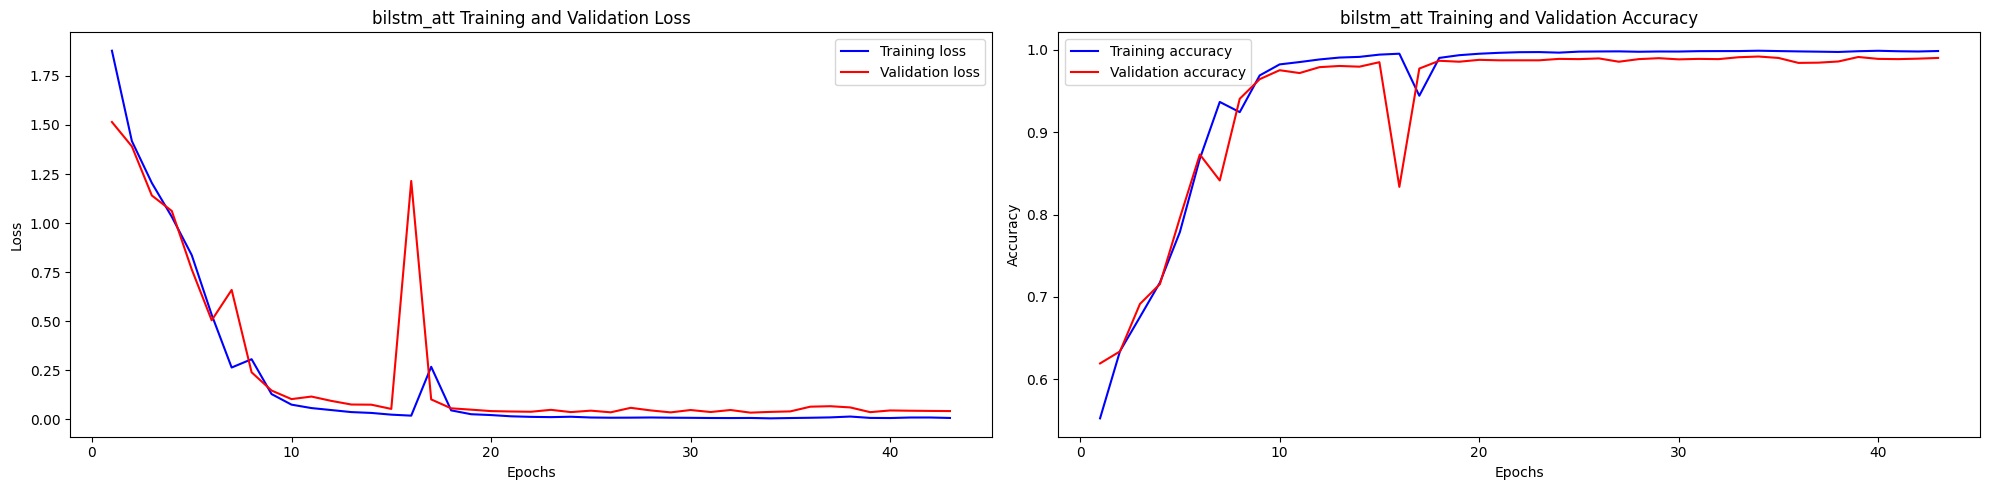

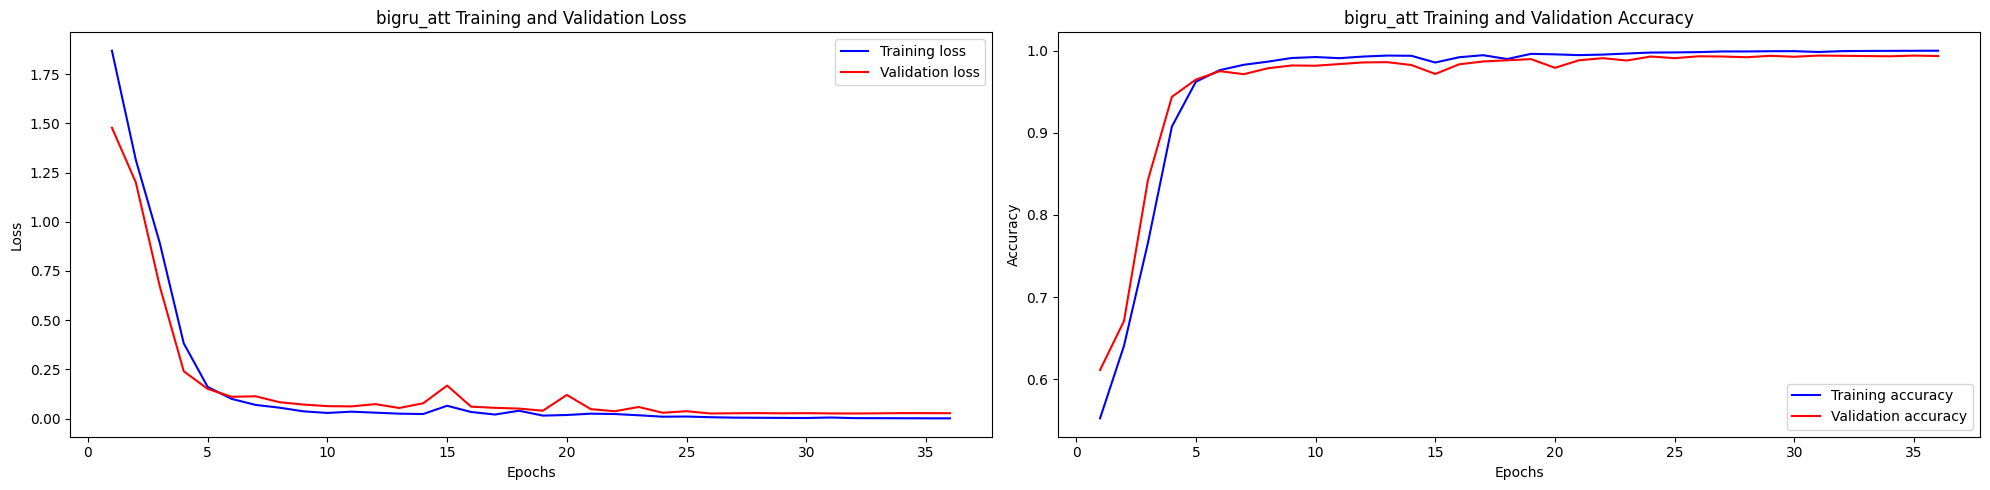

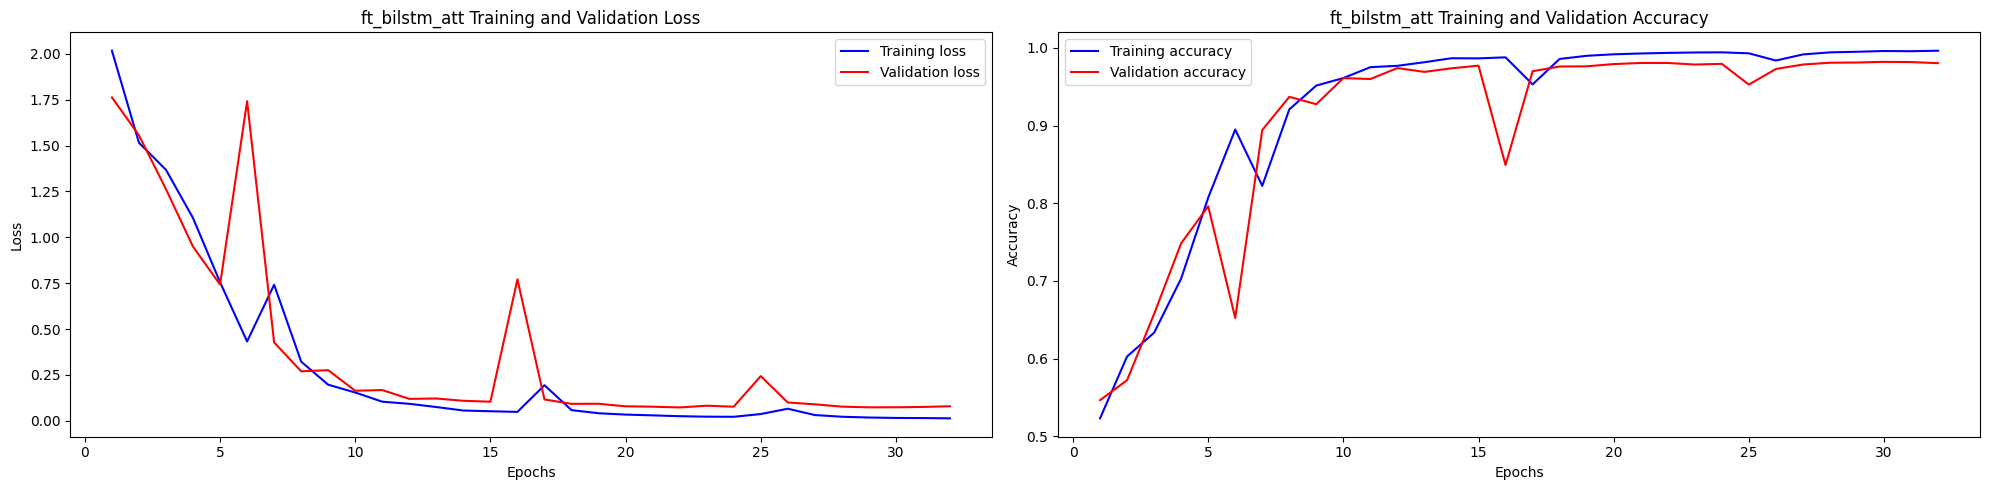

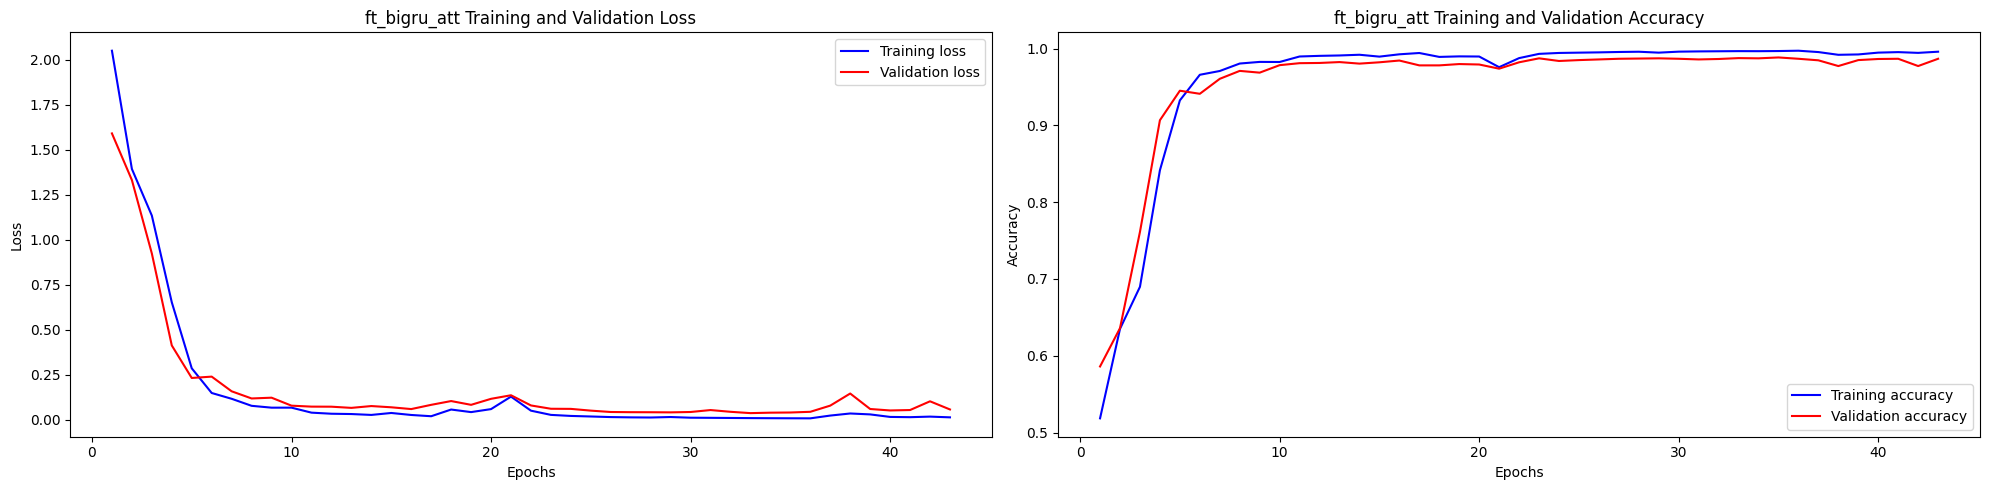

In [46]:
'''
Plot Accuracy and Loss
'''

histories = {
    'bilstm_att': bilstm_att_history,
    'bigru_att': bigru_att_history,
    'ft_bilstm_att': ft_bilstm_att_history,
    'ft_bigru_att': ft_bigru_att_history
}

for model_name, history in histories.items():
    plot_loss_accuracy(model_name, history)

In [47]:
'''
Save model
'''

filename = 'ft_bilstm_att_jawa.pkl'
pickle.dump(ft_bilstm_att, open(filename, 'wb'))
# files.download('ft_bilstm_att_jawa.pkl')

filename = 'ft_bigru_att_jawa.pkl'
pickle.dump(ft_bigru_att, open(filename, 'wb'))
# files.download('ft_bigru_att_jawa.pkl')

filename = 'bilstm_att_jawa.pkl'
pickle.dump(bilstm_att, open(filename, 'wb'))
# files.download('bilstm_att_jawa.pkl')

filename = 'bigru_att_jawa.pkl'
pickle.dump(bigru_att, open(filename, 'wb'))
# files.download('bigru_att_jawa.pkl')

In [48]:
def decode_output(decoder_input, tokenizer):
    output_seq = decoder_input[0, 1:-1]
    predicted_text = ""
    for index in output_seq:
        if index == 0:
            continue
        predicted_char = tokenizer.index_word.get(index, '')
        if predicted_char != ' ':
            predicted_text += predicted_char
    return predicted_text

In [49]:
def predict_latin(input_sequences, model, pegon_tokenizer, latin_tokenizer , pegon_max_length, latin_max_length):
    predictions = []
    for input_sequence in input_sequences:
        encoder_input = np.array([input_sequence])
        decoder_input = np.zeros((1, latin_max_length))
        decoder_input[0, 0] = latin_tokenizer.word_index['\t']

        for i in range(1, latin_max_length):
            pred = model.predict([[encoder_input], decoder_input], verbose=0)[0]
            predicted_token_index = np.argmax(pred[i-1])
            decoder_input[0, i] = predicted_token_index
            if predicted_token_index == latin_tokenizer.word_index['\n']:
                break

        predicted_text = decode_output(decoder_input, latin_tokenizer)
        predictions.append(predicted_text)
    return predictions

In [50]:
'''
Predict Data Validation
'''

bilstm_att_val_pred = predict_latin(X_val, bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bigru_att_val_pred = predict_latin(X_val, bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
ft_bilstm_att_val_pred = predict_latin(X_val, ft_bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
ft_bigru_att_val_pred = predict_latin(X_val, ft_bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

# Error Analysis on Validation Data

In [51]:
'''
Get The Latin and Pegon of Data Train
'''

pegon_train, pegon_test, latin_train, latin_test = train_test_split(train_df['pegon'], train_df['latin'], test_size=1/9, random_state=42)

In [52]:
def calculate_cer(row):
    # Calculate Levenshtein distance between Ground Truth and Predicted strings
    distance = levenshtein_distance(row['Ground Truth'], row['Predicted'])

    # Calculate the length of the target (Ground Truth) string
    length = len(row['Ground Truth'])

    # Calculate CER (Character Error Rate) and handle the case when the length is 0
    return distance / length if length > 0 else np.nan

In [53]:
def create_cer_analysis(result_df):
    # Remove '\n' and '\t' from the dataframe
    result_df = result_df.replace(r'\n', '', regex=True).replace(r'\t', '', regex=True)

    # Calculate CER for each row
    result_df['CER'] = result_df.apply(calculate_cer, axis=1)

    # Calculate mean CER
    cer_mean = result_df['CER'].mean()

    # Filter rows with CER > 0
    error_result = result_df[result_df['CER'] > 0]

    return result_df, cer_mean, error_result

In [54]:
bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bilstm_att_val_pred
})

bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bigru_att_val_pred
})

ft_bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': ft_bilstm_att_val_pred
})

ft_bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': ft_bigru_att_val_pred
})

In [55]:
bilstm_att_result, bilstm_att_cer, bilstm_att_error_result = create_cer_analysis(bilstm_att_result)
bigruatt_result, bigru_att_cer, bigru_att_error_result = create_cer_analysis(bigru_att_result)
ft_bilstm_att_result, ft_bilstm_att_cer, ft_bilstm_att_error_result = create_cer_analysis(ft_bilstm_att_result)
ft_bigruatt_result, ft_bigru_att_cer, ft_bigru_att_error_result = create_cer_analysis(ft_bigru_att_result)

In [56]:
'''
Number of Error Word
'''

print("Total Error Word")
print(f"BiLSTM Attention: {bilstm_att_error_result.shape[0]}")
print(f"BiGRU Attention: {bigru_att_error_result.shape[0]}")
print(f"fastText BiLSTM Attention: {ft_bilstm_att_error_result.shape[0]}")
print(f"fastText BiGRU Attention: {ft_bigru_att_error_result.shape[0]}")

Total Error Word
BiLSTM Attention: 24
BiGRU Attention: 22
fastText BiLSTM Attention: 42
fastText BiGRU Attention: 34


In [57]:
cer_result = pd.DataFrame({
    'Model': ['bilstm_att', 'bigru_att', 'ft_bilstm_att', 'ft_bigru_att'],
    'CER': [bilstm_att_cer, bigru_att_cer, ft_bilstm_att_cer, ft_bigru_att_cer]
})

cer_result_sorted = cer_result.sort_values(by='CER', ascending=True)
cer_result_sorted

,Model,CER
1,bigru_att,0.020466
0,bilstm_att,0.025854
3,ft_bigru_att,0.040698
2,ft_bilstm_att,0.054267


In [58]:
models = ['bilstm_att', 'bigru_att', 'ft_bilstm_att', 'ft_bigru_att']
dfs = [bilstm_att_error_result, bigru_att_error_result, ft_bilstm_att_error_result, ft_bigru_att_error_result]

# Add 'model' column and concatenate dataframes
for i, df in enumerate(dfs):
    df.loc[:, 'model'] = models[i]

val_error_df = pd.concat(dfs, axis=0)

# Group by 'pegon' and 'latin', aggregate 'model' column
val_error_df = val_error_df.groupby(['Pegon', 'Ground Truth', 'Predicted', 'CER'])['model'].agg(lambda x: ', '.join(set(x))).reset_index()
val_error_df = val_error_df.rename(columns={'model': 'models'})

val_error_df.sort_values('Pegon')

<ipython-input-58-d8be3c9493f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'model'] = models[i]
<ipython-input-58-d8be3c9493f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'model'] = models[i]
<ipython-input-58-d8be3c9493f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,Pegon,Ground Truth,Predicted,CER,models
0,الاَئِمَّةِ,al-aimmati,aa-iimmahi,0.300000,ft_bilstm_att
1,الاَئِمَّةِ,al-aimmati,al-aimmahi,0.100000,ft_bigru_att
2,الاَئِمَّةِ,al-aimmati,alaimmati,0.100000,bigru_att
3,التَّارِيْخِ,at-tariḵi,at-tariḏi,0.111111,bilstm_att
4,التَّارِيْخِ,at-tariḵi,at-tariḵih,0.111111,ft_bilstm_att
...,...,...,...,...,...
88,٦,6,3,1.000000,"ft_bigru_att, ft_bilstm_att"
89,٦,6,9,1.000000,bilstm_att
90,٦,6,h,1.000000,bigru_att
91,٧,7,3,1.000000,"ft_bigru_att, ft_bilstm_att"


In [59]:
val_error_df.sort_values('Pegon')

,Pegon,Ground Truth,Predicted,CER,models
0,الاَئِمَّةِ,al-aimmati,aa-iimmahi,0.300000,ft_bilstm_att
1,الاَئِمَّةِ,al-aimmati,al-aimmahi,0.100000,ft_bigru_att
2,الاَئِمَّةِ,al-aimmati,alaimmati,0.100000,bigru_att
3,التَّارِيْخِ,at-tariḵi,at-tariḏi,0.111111,bilstm_att
4,التَّارِيْخِ,at-tariḵi,at-tariḵih,0.111111,ft_bilstm_att
...,...,...,...,...,...
88,٦,6,3,1.000000,"ft_bigru_att, ft_bilstm_att"
89,٦,6,9,1.000000,bilstm_att
90,٦,6,h,1.000000,bigru_att
91,٧,7,3,1.000000,"ft_bigru_att, ft_bilstm_att"


In [60]:
val_error_df.to_excel('val_error.xlsx', index=False)

# Model Testing

In [61]:
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(test_df['pegon'], pegon_tokenizer)

In [62]:
'''
Predict Data Test
'''

bilstm_att_pred_test = predict_latin(padded_pegon, bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bigru_att_pred_test = predict_latin(padded_pegon, bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
ft_bilstm_att_pred_test = predict_latin(padded_pegon, ft_bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
ft_bigru_att_pred_test = predict_latin(padded_pegon, ft_bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

# Error Analysis on Testing Data

In [63]:
pegon_test = test_df['pegon']
latin_test = test_df['latin']

In [64]:
bilstm_att_result_test = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bilstm_att_pred_test
})

bigru_att_result_test = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bigru_att_pred_test
})

ft_bilstm_att_result_test = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': ft_bilstm_att_pred_test
})

ft_bigru_att_result_test = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': ft_bigru_att_pred_test
})

In [65]:
bilstm_att_result_test, bilstm_att_cer_test, bilstm_att_error_result_test = create_cer_analysis(bilstm_att_result_test)
bigru_att_result_test, bigru_att_cer_test, bigru_att_error_result_test = create_cer_analysis(bigru_att_result_test)
ft_bilstm_att_result_test, ft_bilstm_att_cer_test, ft_bilstm_att_error_result_test = create_cer_analysis(ft_bilstm_att_result_test)
ft_bigru_att_result_test, ft_bigru_att_cer_test, ft_bigru_att_error_result_test = create_cer_analysis(ft_bigru_att_result_test)

In [66]:
'''
Number of Error Word
'''

print("Total Error Word")
print(f"BiLSTM Attention: {bilstm_att_error_result_test.shape[0]}")
print(f"BiGRU Attention: {bigru_att_error_result_test.shape[0]}")
print(f"fastText BiLSTM Attention: {ft_bilstm_att_error_result_test.shape[0]}")
print(f"fastText BiGRU Attention: {ft_bigru_att_error_result_test.shape[0]}")

Total Error Word
BiLSTM Attention: 38
BiGRU Attention: 40
fastText BiLSTM Attention: 45
fastText BiGRU Attention: 29


In [67]:
cer_result = pd.DataFrame({
    'Model': ['bilstm_att', 'bigru_att', 'ft_bilstm_att', 'ft_bigru_att'],
    'CER': [bilstm_att_cer_test, bigru_att_cer_test, ft_bilstm_att_cer_test, ft_bigru_att_cer_test]
})

cer_result_sorted = cer_result.sort_values(by='CER', ascending=True)
cer_result_sorted

,Model,CER
3,ft_bigru_att,0.029255
1,bigru_att,0.034344
0,bilstm_att,0.036156
2,ft_bilstm_att,0.044242


In [68]:
models = ['bilstm_att', 'bigru_att', 'ft_bilstm_att', 'ft_bigru_att']
dfs = [bilstm_att_error_result_test, bigru_att_error_result_test, ft_bilstm_att_error_result_test, ft_bigru_att_error_result_test]

# Add 'model' column and concatenate dataframes
for i, df in enumerate(dfs):
    df.loc[:, 'model'] = models[i]

test_error_df = pd.concat(dfs, axis=0)

# Group by 'pegon' and 'latin', aggregate 'model' column
test_error_df = test_error_df.groupby(['Pegon', 'Ground Truth', 'Predicted', 'CER'])['model'].agg(lambda x: ', '.join(set(x))).reset_index()
test_error_df = test_error_df.rename(columns={'model': 'models'})

test_error_df.sort_values('Pegon')

<ipython-input-68-afaf2af61230>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'model'] = models[i]
<ipython-input-68-afaf2af61230>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'model'] = models[i]
<ipython-input-68-afaf2af61230>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,Pegon,Ground Truth,Predicted,CER,models
0,اللّٰهُ,allāhu,al-lāhu,0.166667,"ft_bigru_att, bigru_att"
1,اللّٰهُ,allāhu,al-lāhuhu,0.500000,bilstm_att
2,اللّٰهُ,allāhu,allāhuhu,0.333333,ft_bilstm_att
3,الْعَافِيَةِ,al-'afiyati,al-'afiati,0.090909,"ft_bilstm_att, bigru_att"
4,الْعَظِيْمِ,al-'aẕimi,al-'aimimi,0.222222,bigru_att
...,...,...,...,...,...
99,ڠࣤرُڠُؤْاَكَىْ,ṅěruṅu`ake,ṅěru`uake,0.200000,ft_bilstm_att
100,ڠࣤرُڠُؤْاَكَىْ,ṅěruṅu`ake,ṅěruṅuake,0.100000,ft_bigru_att
101,ۑَاهِىْ,ñahi,ñai,0.250000,"ft_bilstm_att, bigru_att"
102,ࢍَوْلَيْئْ,gole`,gole,0.200000,bilstm_att


In [69]:
test_error_df.to_excel('test_error.xlsx', index=False)

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
import shutil

shutil.copy('pegon_tokenizer_jawa.pkl', '/content/drive/MyDrive/pegon_tokenizer_jawa.pkl')
shutil.copy('latin_tokenizer_jawa.pkl', '/content/drive/MyDrive/latin_tokenizer_jawa.pkl')

shutil.copy('pegon_vectorizer_jawa.pkl', '/content/drive/MyDrive/pegon_vectorizer_jawa.pkl')
shutil.copy('latin_vectorizer_jawa.pkl', '/content/drive/MyDrive/latin_vectorizer_jawa.pkl')

shutil.copy('ft_bilstm_att_jawa.pkl', '/content/drive/MyDrive/ft_bilstm_att_jawa.pkl')
shutil.copy('ft_bigru_att_jawa.pkl', '/content/drive/MyDrive/ft_bigru_att_jawa.pkl')
shutil.copy('bilstm_att_jawa.pkl', '/content/drive/MyDrive/bilstm_att_jawa.pkl')
shutil.copy('bigru_att_jawa.pkl', '/content/drive/MyDrive/bigru_att_jawa.pkl')


'/content/drive/MyDrive/bigru_att_jawa.pkl'